<a href="https://colab.research.google.com/github/stupiddint/Symposium-source-code/blob/main/hai_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
# Standardization 
from sklearn.preprocessing import StandardScaler
import nltk
# remove stopwords
from nltk.corpus import stopwords
# lemmatization & pos tagging
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

from datetime import datetime


In [98]:
df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/HAI_DATASET(N).csv')
df.head()

,PatientID,Age,Sex,MedicalHistory,HospitalizationData,LaboratoryData,ImagingData,MicrobiologyData,RiskFactors,Symptoms,Signs,Treatment,Hospital_Acquired_Infection
0,1,45,M,Hypertension,2020-03-20 to 2020-03-27,Normal,X-ray,Negative,None,"Frequent urination, burning sensation",NaN,Antibiotics prescribed,UTI
1,2,65,F,Diabetes,2020-03-15 to 2020-03-22,Elevated white blood cell count,CT scan,Positive for bacteria,Use of urinary catheter,"Fever, pain in surgical incision site","Redness, swelling at incision site",Antibiotics prescribed,SSI
2,3,50,M,None,2020-03-10 to 2020-03-17,Normal,NaN,Negative,Central venous catheterization,"Fever, chills, elevated heart rate",Positive blood culture,Antibiotics prescribed,CLABSI
3,4,70,F,COPD,2020-03-05 to 2020-03-12,Elevated white blood cell count,Chest X-ray,Positive for bacteria,Mechanical ventilation,"Fever, cough with purulent sputum",Crackles on lung auscultation,Antibiotics prescribed,NaN
4,5,55,M,Asthma,2020-04-02 to 2020-04-09,Elevated white blood cell count,Chest X-ray,Positive for bacteria,Mechanical ventilation,"Shortness of breath, wheezing",Diminished breath sounds,Antibiotics prescribed,VAP


In [99]:
df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   PatientID                    142 non-null    int64 
 1   Age                          142 non-null    int64 
 2   Sex                          142 non-null    object
 3   MedicalHistory               142 non-null    object
 4   HospitalizationData          142 non-null    object
 5   LaboratoryData               142 non-null    object
 6   ImagingData                  99 non-null     object
 7   MicrobiologyData             142 non-null    object
 8   RiskFactors                  142 non-null    object
 9   Symptoms                     142 non-null    object
 10  Signs                        135 non-null    object
 11  Treatment                    142 non-null    object
 12  Hospital_Acquired_Infection  141 non-null    object
dtypes: int64(2), object(11)
memory usag

#finding Y

In [100]:
# df['Hospital_Acquired_Infection'].unique()
# df['Hospital_Acquired_Infection'].value_counts()
# # df['Hospital_Acquired_Infection']= df['Hospital_Acquired_Infection'].replace(['Gastroenteritis',
# #        'Pharyngitis', 'CAP', 'Meningitis'],'other')

df['Hospital_Acquired_Infection']= df['Hospital_Acquired_Infection'].map({'other':0,'VAP':1,'UTI':2,'CLABSI':3,'SSI':4,'Respiratory Infection':5})
df['Hospital_Acquired_Infection'] = df['Hospital_Acquired_Infection'].replace('None', -1)
df['Hospital_Acquired_Infection'] = df['Hospital_Acquired_Infection'].fillna(-1)
df['Hospital_Acquired_Infection'].dropna()
print(len(df['Hospital_Acquired_Infection']))

142


In [101]:
df['Sex'].value_counts()

M    87
F    55
Name: Sex, dtype: int64

#data preprocessing

In [102]:
class Processing:
    def __init__(self, df):
        df1 = df.drop(['PatientID'], axis=1)
        df2 = df1
        for index, row in df2.iterrows():
            try:
                start_date_str, end_date_str = row['HospitalizationData'].split(' to ')
                start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
                end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
                days = (end_date - start_date).days
                df2.at[index, 'HospitalizationData'] = days
            except ValueError:
                print(f"Invalid date range at index {index}: {row['HospitalizationData']}")
        
        df2['Sex'] = df2['Sex'].replace(['Female'], 'F')
        df2['Sex'] = df2['Sex'].replace(['Male'], 'M')
        df2['Sex'] = df2['Sex'].map({'F': 1, 'M': 0}).astype(int)
        df2 = df2.replace('None', -1)
    
        nc = df2.select_dtypes(include=['int', 'float']).columns
        tc = df2.select_dtypes(include='object').columns
        nd = df2[nc]
        td = df2[tc]
        scaler = StandardScaler()
        std_nd = scaler.fit_transform(nd)
        std_nd = pd.DataFrame(std_nd, columns=nd.columns)
        
        # Text preprocessing
        # 1. Lowercase
        # for column in td.columns:
        #     if df2[column].dtype in [np.int64, np.float64]:
        #         continue
        #     else:
        #         td[column] = td[column].str.lower()
        
        # 2. Remove punctuation
        for column in td.columns:
            td[column] = td[column].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)) if isinstance(x, str) else x)
        
        # 3. Remove stopwords
        for column in td.columns:
            stop_words = set(stopwords.words('english'))
            td[column] = td[column].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words]))
        
        # 4. Lemmatizer
        lemmatizer = WordNetLemmatizer()
        
        def lemmatize_word(word, pos_tag):
            if pos_tag.startswith('J'):
                pos = wordnet.ADJ
            elif pos_tag.startswith('V'):
                pos = wordnet.VERB
            elif pos_tag.startswith('N'):
                pos = wordnet.NOUN
            elif pos_tag.startswith('R'):
                pos = wordnet.ADV
            else:
                pos = wordnet.NOUN
            return lemmatizer.lemmatize(word, pos)

        def lemmatize_column(column):
            if column == 'NaN':
                return column
            elif isinstance(column, str):
                tokens = word_tokenize(column)
                pos_tags = nltk.pos_tag(tokens)
                lemmatized_words = [lemmatize_word(word, pos_tag) for word, pos_tag in pos_tags]
                return ' '.join(lemmatized_words)
            else:
                return column
        
        for column in td.columns:
            td.loc[:, column] = td[column].apply(lemmatize_column)
        
        # 5. Vectorizer
        text_columns = ['MedicalHistory', 'LaboratoryData', 'ImagingData', 'MicrobiologyData',
                        'RiskFactors', 'Symptoms', 'Signs', 'Treatment']

        td['Combined Text'] = td[text_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

        vectorizer = TfidfVectorizer()
        vectorized_data = vectorizer.fit_transform(td['Combined Text'])

        self.vectorized_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out())
        self.vectorized_text_data = pd.concat([td, self.vectorized_df], axis=1)
        
        # 6. Combine data
        self.combined_data = pd.concat([nd, self.vectorized_df], axis=1)
        self.combined_data = self.combined_data.fillna(-1)
        # self.combined_data = self.combined_data.dropna()
    
    def process_data(self):
        return self.combined_data


In [103]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [104]:
processing = Processing(df)
combined_data = processing.process_data()

<ipython-input-102-adab19079636>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td[column] = td[column].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)) if isinstance(x, str) else x)
<ipython-input-102-adab19079636>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td[column] = td[column].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words]))
<ipython-input-102-adab19079636>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [105]:
combined_data.head()
# combined_data.info()

,Age,Sex,HospitalizationData,Hospital_Acquired_Infection,abdominal,allergens,angle,antibiotics,asthma,auscultation,...,urine,use,uti,venous,ventilation,vomit,wheezing,white,worsen,xray
0,45,0,7,2.0,0.0,0.0,0.0,0.138927,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.194329
1,65,1,7,4.0,0.0,0.0,0.0,0.086505,0.000000,0.000000,...,0.0,0.193911,0.0,0.000000,0.000000,0.0,0.000000,0.104745,0.0,0.000000
2,50,0,7,3.0,0.0,0.0,0.0,0.138732,0.000000,0.000000,...,0.0,0.000000,0.0,0.288397,0.000000,0.0,0.000000,0.000000,0.0,0.000000
3,70,1,7,-1.0,0.0,0.0,0.0,0.118375,0.000000,0.396564,...,0.0,0.000000,0.0,0.000000,0.193978,0.0,0.000000,0.143336,0.0,0.165582
4,55,0,7,1.0,0.0,0.0,0.0,0.145897,0.206068,0.000000,...,0.0,0.000000,0.0,0.000000,0.239077,0.0,0.206068,0.176661,0.0,0.204079


#model training

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [107]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Columns: 117 entries, Age to xray
dtypes: float64(114), int64(3)
memory usage: 129.9 KB


In [108]:
combined_data.head()

,Age,Sex,HospitalizationData,Hospital_Acquired_Infection,abdominal,allergens,angle,antibiotics,asthma,auscultation,...,urine,use,uti,venous,ventilation,vomit,wheezing,white,worsen,xray
0,45,0,7,2.0,0.0,0.0,0.0,0.138927,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.194329
1,65,1,7,4.0,0.0,0.0,0.0,0.086505,0.000000,0.000000,...,0.0,0.193911,0.0,0.000000,0.000000,0.0,0.000000,0.104745,0.0,0.000000
2,50,0,7,3.0,0.0,0.0,0.0,0.138732,0.000000,0.000000,...,0.0,0.000000,0.0,0.288397,0.000000,0.0,0.000000,0.000000,0.0,0.000000
3,70,1,7,-1.0,0.0,0.0,0.0,0.118375,0.000000,0.396564,...,0.0,0.000000,0.0,0.000000,0.193978,0.0,0.000000,0.143336,0.0,0.165582
4,55,0,7,1.0,0.0,0.0,0.0,0.145897,0.206068,0.000000,...,0.0,0.000000,0.0,0.000000,0.239077,0.0,0.206068,0.176661,0.0,0.204079


In [133]:
combined_data['Hospital_Acquired_Infection'].value_counts()

 5.0    38
 1.0    35
 2.0    23
-1.0    20
 3.0    18
 4.0     8
Name: Hospital_Acquired_Infection, dtype: int64

In [109]:
df['Hospital_Acquired_Infection'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 142 entries, 0 to 141
Series name: Hospital_Acquired_Infection
Non-Null Count  Dtype  
--------------  -----  
142 non-null    float64
dtypes: float64(1)
memory usage: 1.2 KB


In [110]:
X = combined_data.drop('Hospital_Acquired_Infection', axis=1)

y = combined_data['Hospital_Acquired_Infection']
X.info()
print(len(X)
)
print(len(y))
# len(X) == len(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Columns: 116 entries, Age to xray
dtypes: float64(113), int64(3)
memory usage: 128.8 KB
142
142


In [151]:
# X_train.to_csv('hai_X_train.csv', index=False)


In [152]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/content/hai_X_train.csv')

# Get the first row as a separate DataFrame
# first_row = df.head(1)
df.head(1)

,Age,Sex,HospitalizationData,abdominal,allergens,angle,antibiotics,asthma,auscultation,bacteria,...,urine,use,uti,venous,ventilation,vomit,wheezing,white,worsen,xray
0,48,0,7,0.0,0.220517,0.0,0.0,0.393376,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.196688,0.0,0.0,0.194789


In [113]:
# # svm
svm = SVC()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)*100
print("Accuracy:", svm_accuracy, "%")

svm_score = cross_val_score(svm, X_train, y_train, cv=6)
print('svm cross validation score',round(svm_score.mean()*100,2).astype(str),'%' )



Accuracy: 34.48275862068966 %
svm cross validation score 31.92 %


In [157]:
# Random Forest Classifer
rf = RandomForestClassifier(n_estimators=100, random_state=47)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)*100
print("Accuracy:", rf_accuracy, "%")

# rf_score = cross_val_score(rf, X_train, y_train, cv=6)
print('rfc cross validation score',round(rf_score.mean()*100,2).astype(str),'%' )

Accuracy: 100.0 %


TypeError: ignored

In [115]:
#  Naive bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
nb_accuracy = accuracy_score(y_test, y_pred)*100
print("Accuracy:", nb_accuracy, "%")

nb_score= cross_val_score(nb,X_train,y_train,cv=6)
print('naive bayes cross validation score',round(nb_score.mean()*100,2).astype(str),'%' )

Accuracy: 100.0 %
naive bayes cross validation score 95.57 %


In [116]:
# GridSearchCV
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_

y_pred = grid_svc.predict(X_test)
svc_accuracy = accuracy_score(y_test, y_pred)*100
print("Accuracy:", nb_accuracy, "%")

svc_score= cross_val_score(svc,X_train,y_train,cv=6)
print('svc cross validation score',round(svc_score.mean()*100,2).astype(str),'%' )

Accuracy: 100.0 %
svc cross validation score 96.44 %


In [117]:
# # Gradient boost classifier
# xgb= GradientBoostingClassifier(n_estimators = 300,max_depth=1,subsample=0.8,max_features=0.2,random_state=42)
# xgb.fit(X_train,y_train)
# y_pred= xgb.predict(X_test)
# xgb_accuracy= accuracy_score(y_test,y_pred)*100
# print("Accuracy",xgb_accuracy)


# xgb_score= cross_val_score(xgb,X_train,y_train,cv=4)
# print('Gradient Xboost cross validation score', round(xgb_score.mean()*100,2).astype(str),'%')


#Visualization

In [120]:
algorithms = ["SVM","Random Forest", "Gaussian NB","GridSearchCV"]
accuracy = [svm_accuracy, rf_accuracy, nb_accuracy,svc_accuracy]
# cross_val_score = [svm_score,rf_score,nb_score,xgb_score,svc_score]
cross_val_score = [round(svm_score.mean()*100,2),round(rf_score.mean()*100,2),round(nb_score.mean()*100,2),round(svc_score.mean()*100,2)]

results = pd.DataFrame({"Algorithm": algorithms, "Accuracy": accuracy, "cross_val_score": cross_val_score})
results.head()

,Algorithm,Accuracy,cross_val_score
0,SVM,34.482759,31.92
1,Random Forest,100.000000,95.57
2,Gaussian NB,100.000000,95.57
3,GridSearchCV,100.000000,96.44


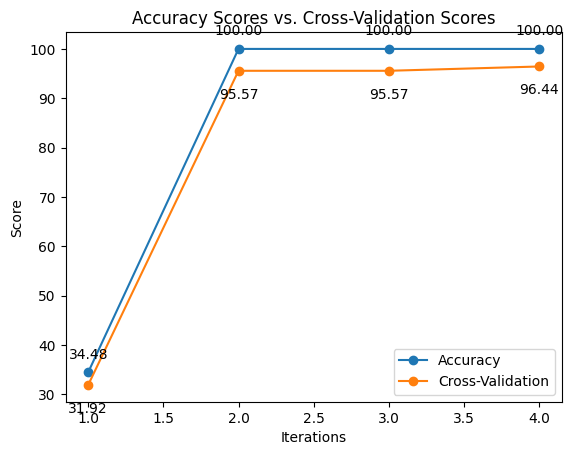

In [122]:
# x-axis values (e.g., number of iterations or epochs)
x_values = [1, 2, 3, 4]
acc= results['Accuracy']
cv_scores= results['cross_val_score']

plt.plot(x_values, results['Accuracy'], marker='o', label='Accuracy')
plt.plot(x_values, results['cross_val_score'], marker='o', label='Cross-Validation')

# Adding labels and title
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('Accuracy Scores vs. Cross-Validation Scores')

for i in range(len(x_values)):
    plt.annotate(f'{acc[i]:.2f}', (x_values[i], acc[i]), 
                 textcoords="offset points", xytext=(0, 10), ha='center')
    plt.annotate(f'{cv_scores[i]:.2f}', (x_values[i], cv_scores[i]), 
                 textcoords="offset points", xytext=(0, -20), ha='center')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

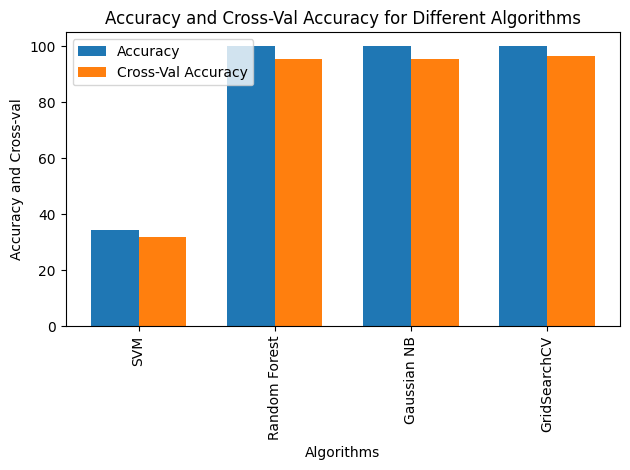

In [123]:
# grouped bar chart
algorithms = ["SVM","Random Forest", "Gaussian NB","GridSearchCV"]
accuracy = [svm_accuracy, rf_accuracy, nb_accuracy,svc_accuracy]
# cross_val_score = [svm_score,rf_score,nb_score,xgb_score,svc_score]
cross_val_score = [round(svm_score.mean()*100,2),round(rf_score.mean()*100,2),round(nb_score.mean()*100,2), round(svc_score.mean()*100,2)]

bar_width = 0.35
index = np.arange(len(algorithms))

plt.bar(index, accuracy, bar_width, label='Accuracy')
plt.bar(index + bar_width, cross_val_score, bar_width, label='Cross-Val Accuracy')

plt.xlabel('Algorithms')
plt.ylabel('Accuracy and Cross-val')
plt.title('Accuracy and Cross-Val Accuracy for Different Algorithms')
plt.xticks(index + bar_width / 2, algorithms, rotation='vertical')
plt.legend()

plt.tight_layout()
plt.show()




In [124]:
from sklearn.metrics import classification_report


y_pred_svm = svm.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_nb = nb.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svm))

print('Random Forest Classifier:')
print(classification_report(y_test, y_pred_rf))

print('Naive Bayes:')
print(classification_report(y_test, y_pred_nb))

# print('Xgboost:')
# print(classification_report(y_test, y_pred_xgb))

Support Vector Classifier:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         8
         1.0       0.33      0.43      0.38         7
         2.0       0.00      0.00      0.00         3
         3.0       0.00      0.00      0.00         4
         5.0       0.35      1.00      0.52         7

    accuracy                           0.34        29
   macro avg       0.14      0.29      0.18        29
weighted avg       0.16      0.34      0.22        29

Random Forest Classifier:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00         8
         1.0       1.00      1.00      1.00         7
         2.0       1.00      1.00      1.00         3
         3.0       1.00      1.00      1.00         4
         5.0       1.00      1.00      1.00         7

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#output predicting

In [125]:
data_list = [1, 45, 'M', 'Asthma, Hypertension', '2023-01-05 to 2023-01-12', 'Blood Test: Normal, X-ray: Clear', 'MRI: No abnormalities', 'NonNasal swab: Positive for influenzae', 'Obesity, Smoking', 'Cough, Fever', 'Elevated heart rate', 'Antibiotics']
columns = ['PatientID','Age', 'Sex','MedicalHistory', 'HospitalizationData', 'LaboratoryData', 'ImagingData', 'MicrobiologyData', 'RiskFactors', 'Symptoms', 'Signs', 'Treatment']
df_new = pd.DataFrame([data_list], columns=columns)
test_df = Processing(df_new)
X_data = test_df.process_data()
X_data.head()

# Step 1: Get feature names used during training
feature_names_training = X_train.columns.tolist()

# Step 2: Align feature names in test data
feature_names_test = X_data.columns.tolist()

# Step 3: Identify unseen features in test data
unseen_features = set(feature_names_test) - set(feature_names_training)

# Step 4: Drop unseen features from test data
X_data = X_data.drop(unseen_features, axis=1)

# Step 5: Reorder features in test data to match the order in training data
X_data = X_data.reindex(columns=feature_names_training, fill_value=0)

# # Step 6: Make predictions using the Random Forest classifier
# predict = rf.predict(X_data)
# print(predict)


<ipython-input-102-adab19079636>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td[column] = td[column].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)) if isinstance(x, str) else x)
<ipython-input-102-adab19079636>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td[column] = td[column].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words]))
<ipython-input-102-adab19079636>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [146]:
# predict = grid_svc.predict(X_data)
predict = rf.predict(X_data)
predict = predict.astype(int)
print(predict)

[3]


In [156]:
# Define a dictionary to map the numeric labels to their corresponding strings
label_mapping = {-1: 'None', 0: 'other' , 1 : 'VAP', 2 : 'UTI', 3 : 'CLABSI', 4: 'SSI', 5 : 'Respiratory Infection'}
predict = [3.]
# Map the predicted values to their corresponding strings
predict_strings = [label_mapping[label] for label in predict]
# Print the predicted strings
for prediction in predict_strings:
    print(prediction)

CLABSI


#saving the model

In [148]:
# !pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [149]:
# import pickle

# filename = 'hai_pred_model.sav'
# pickle.dump(rf, open(filename, 'wb'))



In [150]:
# loading the model
model = pickle.load(open('hai_pred_model.sav', 'rb'))

predict = model.predict(X_data)
print(predict)

[3.]
